In [27]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
import tqdm
import os
import glob
import matplotlib.pyplot as plt

In [28]:

event_counts = {
    'E1': 80,
    'E10': 311,
    'E11': 292,
    'E12': 2,
    'E13': 292,
    'E14': 20,
    'E2': 1,
    'E3': 80,
    'E4': 5,
    'E5': 1,
    'E6': 314,
    'E7': 115,
    'E8': 224,
    'E9': 263
}


max_count = max(event_counts.values())

# Normalize the weights to a scale from 0 to 1
normalized_weights = {event: count / max_count for event, count in event_counts.items()}

print(normalized_weights)


{'E1': 0.25477707006369427, 'E10': 0.9904458598726115, 'E11': 0.9299363057324841, 'E12': 0.006369426751592357, 'E13': 0.9299363057324841, 'E14': 0.06369426751592357, 'E2': 0.0031847133757961785, 'E3': 0.25477707006369427, 'E4': 0.01592356687898089, 'E5': 0.0031847133757961785, 'E6': 1.0, 'E7': 0.3662420382165605, 'E8': 0.7133757961783439, 'E9': 0.8375796178343949}


In [29]:

# event_counts = {
#     'E1': 1,
#     'E10': 1,
#     'E11': 1,
#     'E12': 1,
#     'E13': 1,
#     'E14': 1,
#     'E2': 1,
#     'E3': 1,
#     'E4': 1,
#     'E5': 1,
#     'E6': 1,
#     'E7': 1,
#     'E8': 1,
#     'E9': 1
# }


# max_count = max(event_counts.values())

# # Normalize the weights to a scale from 0 to 1
# normalized_weights = {event: count / max_count for event, count in event_counts.items()}

# print(normalized_weights)


In [30]:
def calculate_ga(df, weights=None):
    # Group the DataFrame by the ground truth template
    grouped = df.groupby('LogTemplate')
    correctly_grouped = 0
    total_weight = 0
    
    # Iterate through each group
    for log_template, group in grouped:
        # Use provided weight or default to 1 if weights not specified or the template is not in the weights dictionary
        group_weight = weights.get(log_template, 1) if weights else 1
        if group['LLMOutput'].nunique() == 1:
            correctly_grouped += group_weight * len(group)
        
        total_weight += group_weight * len(group)
    
    if total_weight == 0:
        ga = 0
    else: ga = correctly_grouped / total_weight
    return ga

In [31]:
def calculate_pa(df, weights=None):
    correctly_parsed = 0
    total_weight = 0
    
    for idx, row in df.iterrows():
        ground_truth_tokens = row['LogTemplate'].split()
        parsed_tokens = row['LLMOutput'].split()
        
        if len(ground_truth_tokens) != len(parsed_tokens):
            continue
        
        correct = True
        for gt_token, parsed_token in zip(ground_truth_tokens, parsed_tokens):
            if (gt_token == "<*>" and parsed_token != "<*>") or (gt_token != "<*>" and gt_token != parsed_token):
                correct = False
                break
        
        event_id = row['EventId']
        weight = weights.get(event_id, 1) if weights else 1
        
        if correct:
            correctly_parsed += weight
        
        total_weight += weight
        
    if total_weight == 0:
        pa = 0
    else: pa = correctly_parsed / total_weight
    return pa

In [32]:

def calculate_template_accuracies(df):
    total_messages = 0
    correct_parsing_templates = 0
    null_logids = df[~df['LogTemplate'].isnull()].index
    df = df.loc[null_logids]
    series_groundtruth = df['LogTemplate']
    series_parsedlog = df['LLMOutput']
    series_groundtruth_valuecounts = series_groundtruth.value_counts()

    df_combined = pd.concat([series_groundtruth, series_parsedlog], axis=1, keys=['groundtruth', 'parsedlog'])
    grouped_df = df_combined.groupby('parsedlog')
    
    for identified_template, group in grouped_df:
        total_messages += 1
        corr_oracle_templates = set(list(group['groundtruth']))
        if corr_oracle_templates == {identified_template}:
            correct_parsing_templates += 1

    PTA = correct_parsing_templates / total_messages
    RTA = correct_parsing_templates / len(series_groundtruth_valuecounts)
    
    return PTA, RTA


def calculate_f1ta(pta, rta):
    if pta + rta == 0:
        return 0.0
    return 2 * (pta * rta) / (pta + rta)

In [33]:
def compute(df, weights=None):
    # Compute metrics
    ga = calculate_ga(df, weights)
    pa = calculate_pa(df, weights)
    pta, rta = calculate_template_accuracies(df)
    f1ta = calculate_f1ta(pta, rta)

    return {'Grouping Accuracy (GA)': ga,
            'Parsing Accuracy (PA)': pa,
            'Precision Template Accuracy (PTA)': pta,
            'Recall Template Accuracy (RTA)': rta,
            'F1-score-TA (F1TA)': f1ta}

In [34]:
def load_csvs_from_folder(folder_path):

    csv_files = sorted(glob.glob(os.path.join(folder_path, '*.csv')))
    

    dataframes = {}
    

    for i, file in enumerate(csv_files):
        df = pd.read_csv(file)
        dataframes[f'df{i}'] = df
    
    return dataframes

In [35]:
dataframes = load_csvs_from_folder("data\parsed\\3Parsed")
dataframes

{'df0':     EventId                           LogTemplate  \
 0        E1  <*>:<*> Served block blk_<*> to /<*>   
 1        E1  <*>:<*> Served block blk_<*> to /<*>   
 2        E1  <*>:<*> Served block blk_<*> to /<*>   
 3        E1  <*>:<*> Served block blk_<*> to /<*>   
 4        E1  <*>:<*> Served block blk_<*> to /<*>   
 ..      ...                                   ...   
 135     E14    Verification succeeded for blk_<*>   
 136     E14    Verification succeeded for blk_<*>   
 137     E14    Verification succeeded for blk_<*>   
 138     E14    Verification succeeded for blk_<*>   
 139     E14    Verification succeeded for blk_<*>   
 
                                                    Log  \
 0    <B>081109 213908 2549 INFO dfs.DataNode$DataXc...   
 1    <B>081109 213847 2552 INFO dfs.DataNode$DataXc...   
 2    <B>081109 213907 2497 INFO dfs.DataNode$DataXc...   
 3    <B>081109 213908 2549 INFO dfs.DataNode$DataXc...   
 4    <B>081109 213907 2497 INFO dfs.DataNode$Da

In [36]:

compute(dataframes['df0'], normalized_weights)

{'Grouping Accuracy (GA)': 1.0,
 'Parsing Accuracy (PA)': 1.0,
 'Precision Template Accuracy (PTA)': 0.9285714285714286,
 'Recall Template Accuracy (RTA)': 0.9285714285714286,
 'F1-score-TA (F1TA)': 0.9285714285714286}

In [37]:

compute(dataframes['df1'], normalized_weights)

{'Grouping Accuracy (GA)': 1.0,
 'Parsing Accuracy (PA)': 0.6240000000000006,
 'Precision Template Accuracy (PTA)': 0.6428571428571429,
 'Recall Template Accuracy (RTA)': 0.6428571428571429,
 'F1-score-TA (F1TA)': 0.6428571428571429}

In [38]:
compute(dataframes['df2'], normalized_weights)

{'Grouping Accuracy (GA)': 1.0,
 'Parsing Accuracy (PA)': 0.7310000000000001,
 'Precision Template Accuracy (PTA)': 0.7142857142857143,
 'Recall Template Accuracy (RTA)': 0.7142857142857143,
 'F1-score-TA (F1TA)': 0.7142857142857143}

In [39]:
compute(dataframes['df3'], normalized_weights)

{'Grouping Accuracy (GA)': 1.0,
 'Parsing Accuracy (PA)': 0.6000000000000002,
 'Precision Template Accuracy (PTA)': 0.6428571428571429,
 'Recall Template Accuracy (RTA)': 0.6428571428571429,
 'F1-score-TA (F1TA)': 0.6428571428571429}

In [40]:
compute(dataframes['df4'], normalized_weights)

{'Grouping Accuracy (GA)': 1.0,
 'Parsing Accuracy (PA)': 0,
 'Precision Template Accuracy (PTA)': 0.0,
 'Recall Template Accuracy (RTA)': 0.0,
 'F1-score-TA (F1TA)': 0.0}

In [41]:
path = "data\HDFS_2K\HDFS_2k.log_structured.csv"
df = pd.read_csv(path)
df_filtered = df.groupby('EventId')["EventTemplate"].count()
df_filtered

EventId
E1      80
E10    311
E11    292
E12      2
E13    292
E14     20
E2       1
E3      80
E4       5
E5       1
E6     314
E7     115
E8     224
E9     263
Name: EventTemplate, dtype: int64

In [42]:
def plot_metrics(dataframes):
    metrics = ['Grouping Accuracy (GA)', 'Parsing Accuracy (PA)', 
               'Precision Template Accuracy (PTA)', 
               'Recall Template Accuracy (RTA)', 'F1-score-TA (F1TA)']
    metrics = ['Parsing Accuracy (PA)', 'F1-score-TA (F1TA)']
    
    num_metrics = len(metrics)
    
    for metric in metrics:
        values =  [compute(dataframes[df], normalized_weights)[metric] for df in dataframes]
        
        plt.figure(figsize=(4, 3))
        plt.bar(range(len(dataframes)), values, align='center', alpha=0.5)
        plt.xticks(range(len(dataframes)), dataframes.keys())
        plt.xlabel('DataFrame')
        plt.ylabel(metric)
        plt.title(f'{metric} for each DataFrame')
        plt.show()



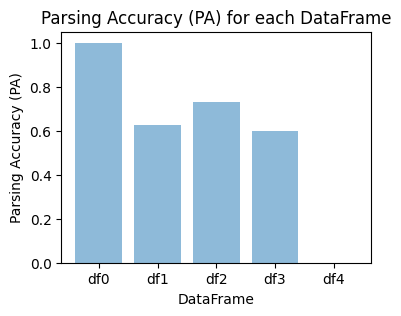

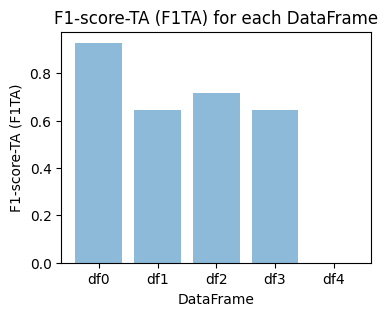

In [43]:
dataframes = load_csvs_from_folder("data\parsed\\3Parsed")
plot_metrics(dataframes)

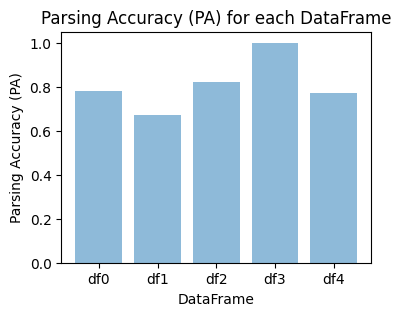

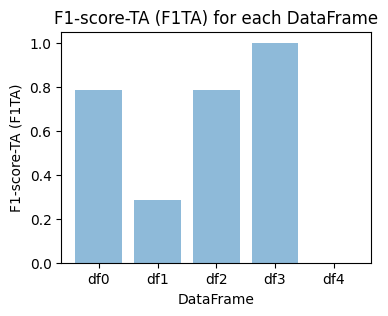

In [44]:
dataframes = load_csvs_from_folder("data\parsed\\4Parsed")
plot_metrics(dataframes)

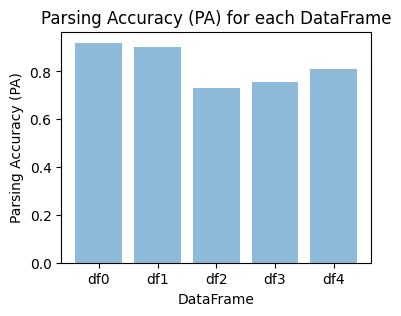

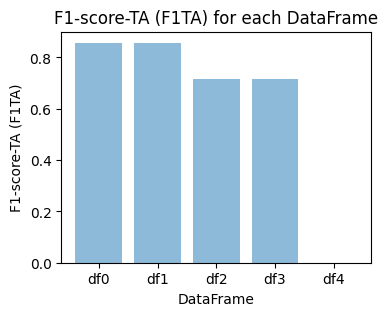

In [45]:
dataframes = load_csvs_from_folder("data\parsed\\5Parsed")
plot_metrics(dataframes)

In [46]:
ab_df3 = pd.read_csv("data\parsed\\abl3")
plot_metrics(ab_df3)

PermissionError: [Errno 13] Permission denied: 'data\\parsed\\abl3'

In [ ]:
ab_df5 = pd.read_csv("data\parsed\\abl5")
plot_metrics(ab_df5)

PermissionError: [Errno 13] Permission denied: 'data\\parsed\\abl5'